# Data Analysis

## Imports

In [1]:
%matplotlib inline

import pandas as pd
pd.options.display.max_rows = 999
import sqlite3
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Functions

In [2]:
def normalize(df, feature):
    '''Normalize data'''
    return (df[feature] - df[feature].mean()) / df[feature].std()

def removeOutliers(df, feature):
    '''Remove outliers (more than 3 std devs from mean)'''
    return df[np.abs(df[feature] - df[feature].mean()) <= (3 * df[feature].std())]

def convert_perc_int(df):
    ''''''
    df["occupancy"] = df["occupancy"].apply(lambda x: x * 100)
    df["occupancy"] = df["occupancy"].astype(int)
    return df

## ABT Construction

#### Database Connection

In [3]:
conn = sqlite3.connect("./project/restimator.db")

### Occupy Dataframe

In [4]:
df_occupy_1 = pd.read_sql(sql="SELECT room, date, time, associated_client_count, authenticated_client_count FROM occupy", con=conn)
df_occupy_2 = pd.read_sql(sql="SELECT room, date, time, module_code, occupancy FROM occupy", con=conn)

#### Only consider rows with the following conditions satisfied:

* **Condition 1**: time between 9:00 and 16:00
* **Condition 2**:  
    - time >= quarter past the hour: account for DHCP lease duration
    - time <= quarter to the hour: account for classes ending early

This condition is because we want to take the average authenticated client count between these times. We are disregarding the other figures because we are not sure of the DHCP lease duration. For instance, a number of the devices could still be being considered from an individual who has already left the room but the lease is still considered.


In [5]:
df_occupy_1["condition1"] = df_occupy_1["time"].apply(lambda x: "true" if 16 >= int(x[0:2]) >= 9 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition1"] == "true"]

In [6]:
df_occupy_1["condition2"] = df_occupy_1["time"].apply(lambda x: "true" if 45 >= int(x[-2:]) >= 15 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition2"] == "true"]

In [7]:
del df_occupy_1["condition1"]
del df_occupy_1["condition2"]
df_occupy_1["time"] = df_occupy_1["time"].apply(lambda x: x[0:3] + "00")

#### Merge tables and get average

In [8]:
df_occupy_merge = pd.merge(left = df_occupy_1, right = df_occupy_2, how="outer", on=["room", "date", "time"])

In [9]:
df_occupy = df_occupy_merge.groupby(["room", "date", "time", "module_code"], as_index=False).mean()
df_occupy = df_occupy.dropna() 
print(df_occupy.shape)

(153, 7)


#### Module Dataframe

In [10]:
df_module = pd.read_sql(sql="SELECT * FROM module", con=conn)

#### Location Dataframe

In [11]:
df_location = pd.read_sql(sql="SELECT * FROM location", con=conn)

#### Close db connection

In [12]:
conn.close()

#### Join tables

In [13]:
df_abt = pd.merge(left = df_occupy, right = df_module, how="outer", on=["module_code"]) 
df_abt = pd.merge(left = df_abt, right = df_location, how="outer", on=["room"]) 
df_abt = df_abt.dropna() 
print(df_abt.shape)

(152, 11)


#### Remove rows without registered students i.e. no class (only consider where those classes with modules taking place)

In [14]:
df_abt = df_abt[df_abt["reg_students"] != 0]
print(df_abt.shape)

(128, 11)


#### Add occupancy ground truth number to ABT (Capacity * GT%)

In [15]:
df_abt["occupancy_number"] = df_abt["occupancy"] * df_abt["capacity"]

#### Show error in GT i.e. difference between registered students and GT

In [16]:
df_abt["Difference"] = df_abt["occupancy_number"] - df_abt["reg_students"]
df_abt["max_error"] = df_abt["capacity"].apply(lambda x: x * .125)

In [17]:
error = df_abt[df_abt["Difference"] >= df_abt["max_error"]]
error[["room","date","time","reg_students","occupancy_number","Difference","max_error"]]

,room,date,time,reg_students,occupancy_number,Difference,max_error
4,B-002,2015-11-03,11:00,18,45.0,27.0,11.25
9,B-002,2015-11-03,12:00,27,45.0,18.0,11.25
15,B-002,2015-11-03,14:00,42,67.5,25.5,11.25
59,B-004,2015-11-13,15:00,38,80.0,42.0,20.00
97,B-004,2015-11-12,10:00,56,80.0,24.0,20.00
107,B-004,2015-11-09,15:00,19,80.0,61.0,20.00
116,B-003,2015-11-03,11:00,56,67.5,11.5,11.25


#### Remove those rows outside an acceptable error range

In [18]:
df_abt = df_abt[df_abt["Difference"] <= df_abt["max_error"]]
print(df_abt.shape)

(121, 14)


#### Take min between occupancy gt and reg students to remove error in gt measurement

In [19]:
df_abt["min_occ_reg"] = df_abt.loc[:, ['occupancy_number', 'reg_students']].min(axis=1)
print(df_abt.shape)

(121, 15)


## Simple Linear Regression Models

### Model 1: Simple Linear Regression (Y: min_occ_reg, X: authenticated_client_count)

In [20]:
df_reg_1= df_abt[["min_occ_reg", "authenticated_client_count"]].copy()
print(df_reg_1.shape)

(121, 2)


#### Feature Analysis

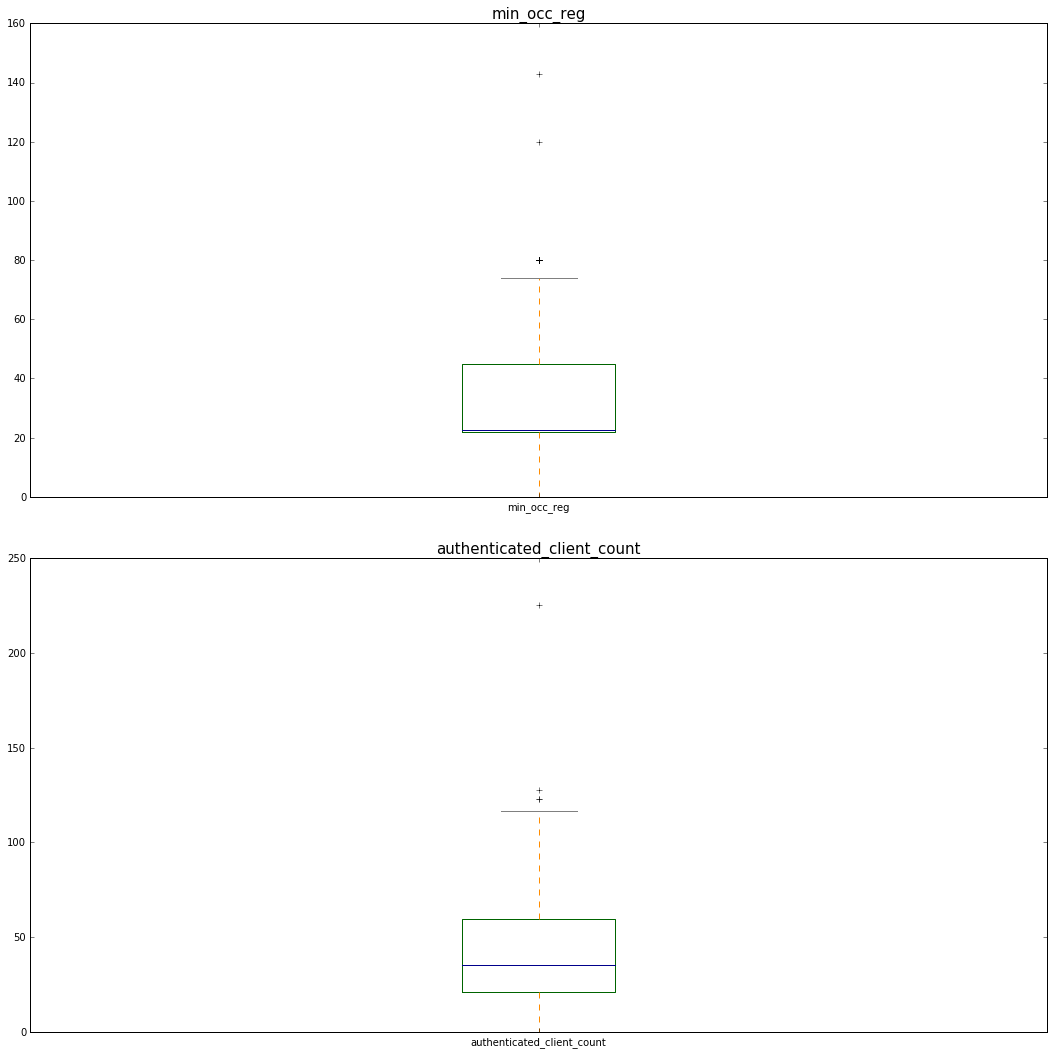

In [21]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') 
plt.figure() 
plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_1["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df_reg_1["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0)

#### Normalize Features and remove outliers

In [22]:
df_reg_1["min_occ_reg_NORM"] = normalize(df_reg_1, "min_occ_reg")
df_reg_1["auth_client_count_NORM"] = normalize(df_reg_1, "authenticated_client_count")
print(df_reg_1.shape)
df_reg_1 = removeOutliers(df_reg_1, "min_occ_reg_NORM")
df_reg_1 = removeOutliers(df_reg_1, "auth_client_count_NORM")
df_reg_1 = df_reg_1[["min_occ_reg", "authenticated_client_count"]]
print(df_reg_1.shape)

(121, 4)
(118, 2)


In [23]:
print(df_reg_1.dtypes)
corrMatrix = df_reg_1.corr()
corrMatrix

min_occ_reg                   float64
authenticated_client_count    float64
dtype: object


,min_occ_reg,authenticated_client_count
min_occ_reg,1.000000,0.717987
authenticated_client_count,0.717987,1.000000


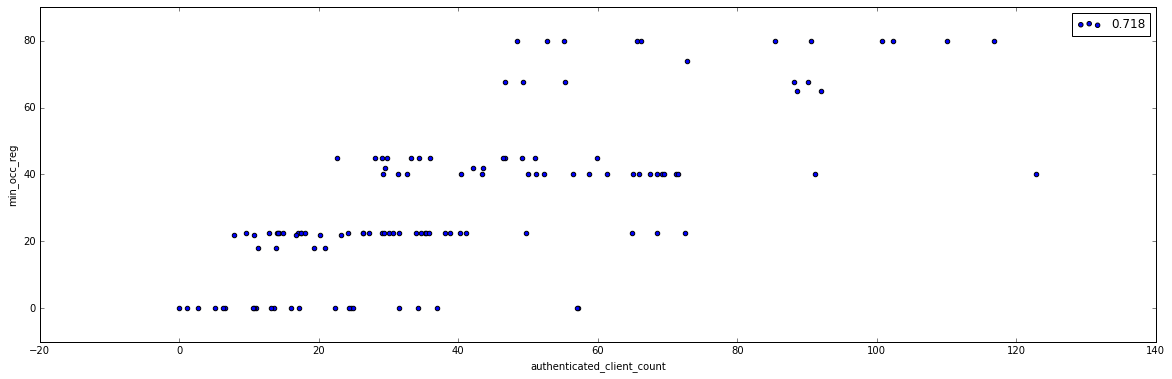

In [24]:
plt.figure() 
df_reg_1.plot(kind="scatter", x="authenticated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

#### Statsmodels

In [25]:
# lm_sm = sm.ols(formula="min_occ_reg ~ authenticated_client_count", data=df_reg_1).fit()
# print(lm_sm.summary())

#### Scikit Learn

Coefficients: 
 [ 0.62967539]
Intercept: 
 6.35641943526
Residual sum of squares: 270.72
Square Root of Residual sum of squares: 16.45
Variance score: 0.52


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


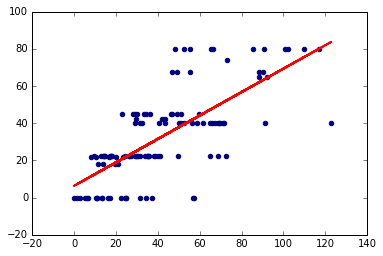

In [26]:
X = df_reg_1["authenticated_client_count"].reshape(len(df_reg_1["authenticated_client_count"]), 1)
y = df_reg_1["min_occ_reg"]

lm_scikit_1 = LinearRegression()

# Fit the model 
lm_scikit_1.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_1.coef_)
# The intercept
print('Intercept: \n', lm_scikit_1.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y, lm_scikit_1.predict(X)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y, lm_scikit_1.predict(X))))
# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_1.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_1.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

#### Train & Testing

**Cross Validation**

In [27]:
R2_scores_1 = cross_val_score(lm_scikit_1.fit(X, y), X.astype(int), y.astype(int), cv=5, scoring="r2")
print("Accuracy: %0.2f (+/- %0.2f)" % (R2_scores_1.mean(), R2_scores_1.std() * 2))

Accuracy: 0.30 (+/- 0.25)


In [28]:
R2_scores_1 = cross_val_score(lm_scikit_1.fit(X, y), X.astype(int), y.astype(int), cv=5, scoring="r2")
print(R2_scores_1)
print(R2_scores_1.mean())

[ 0.16406108  0.16743704  0.32248866  0.48245065  0.3806237 ]
0.303412225252


**Train and test** 

Coefficients:  [ 0.58632434]
Intercept:  8.93141780983
Residual sum of squares: 316.11
Square Root of Residual sum of squares: 17.78
Variance score: 0.51


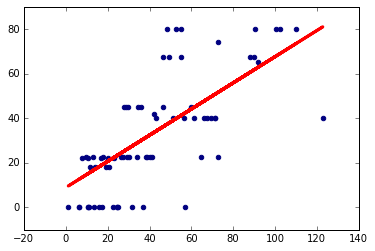

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6)

lm_scikit_1_t = LinearRegression()

# Train the model using the training sets
lm_scikit_1_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: ', lm_scikit_1_t.coef_)
# The intercept
print('Intercept: ', lm_scikit_1_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_1_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_1_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_1_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

### Model 2: Simple Linear (Y: min_occ_reg, X: asso_client_count)

In [30]:
df_reg_2= df_abt[["min_occ_reg", "associated_client_count"]].copy()
print(df_reg_2.shape)

(121, 2)


#### Feature Analysis

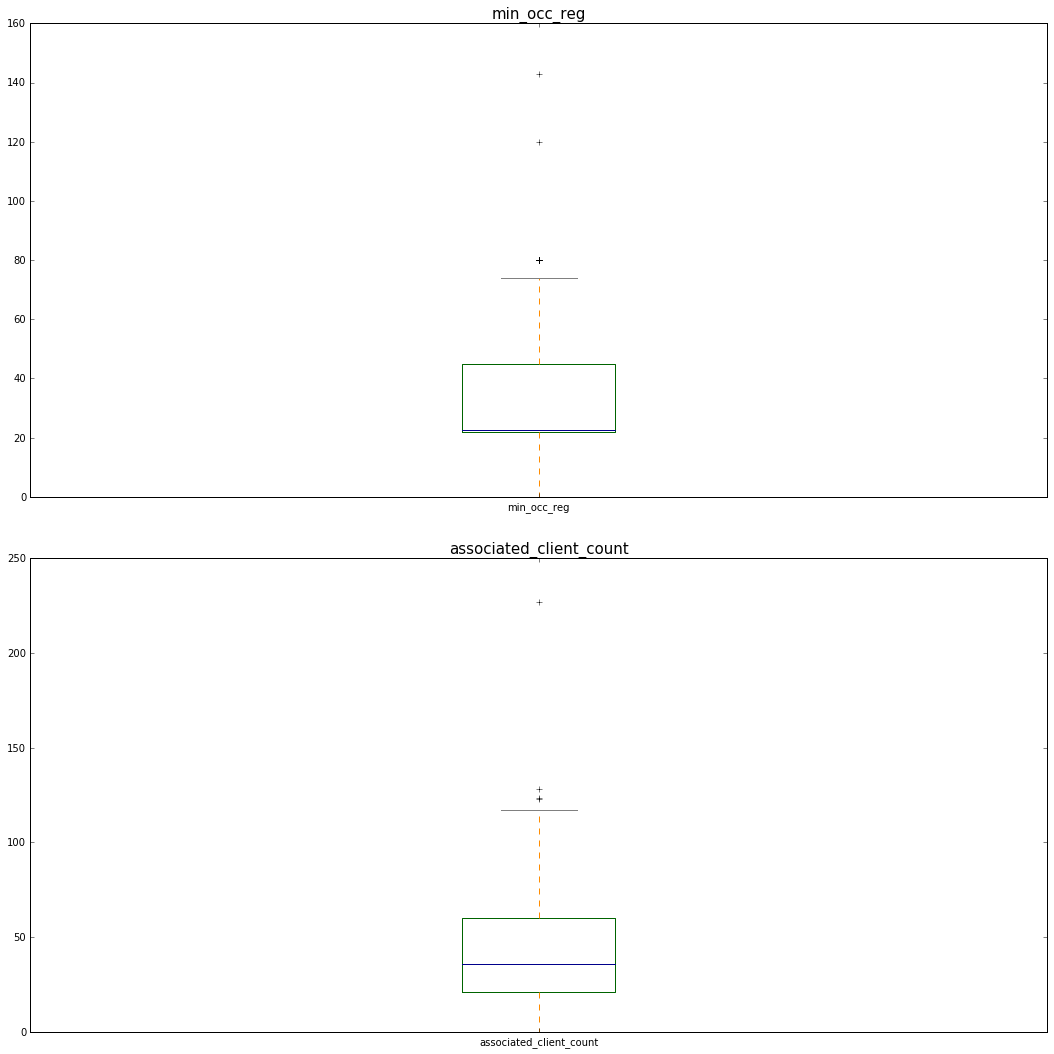

In [31]:
plt.figure() 
plt.subplot(211).set_title("min_occ_reg", fontsize=15)
df_reg_2["min_occ_reg"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("associated_client_count", fontsize=15)
df_reg_2["associated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding

#### Normalize Features and remove outliers

In [32]:
df_reg_2["min_occ_reg_NORM"] = normalize(df_reg_2, "min_occ_reg")
df_reg_2["asso_client_count_NORM"] = normalize(df_reg_2, "associated_client_count")
print(df_reg_2.shape)
df_reg_2 = removeOutliers(df_reg_2, "min_occ_reg_NORM")
df_reg_2 = removeOutliers(df_reg_2, "asso_client_count_NORM")
df_reg_2 = df_reg_2[["min_occ_reg", "associated_client_count"]]
print(df_reg_2.shape)

(121, 4)
(118, 2)


In [33]:
print(df_reg_2.dtypes)
corrMatrix = df_reg_2.corr()
corrMatrix

min_occ_reg                float64
associated_client_count    float64
dtype: object


,min_occ_reg,associated_client_count
min_occ_reg,1.000000,0.717581
associated_client_count,0.717581,1.000000


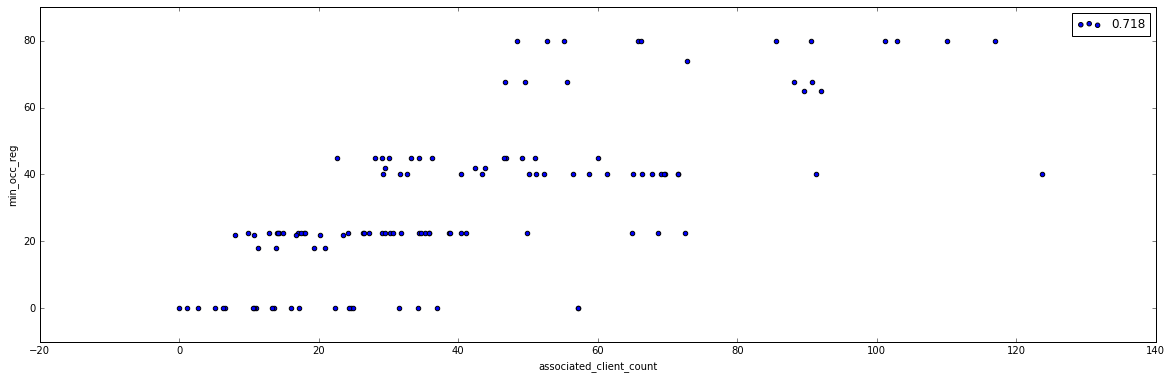

In [34]:
plt.figure() 
df_reg_2.plot(kind="scatter", x="associated_client_count", y="min_occ_reg", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

Coefficients: 
 [ 0.62746015]
Intercept: 
 6.38138235553
Residual sum of squares: 271.05
Square Root of Residual sum of squares: 16.46
Variance score: 0.51


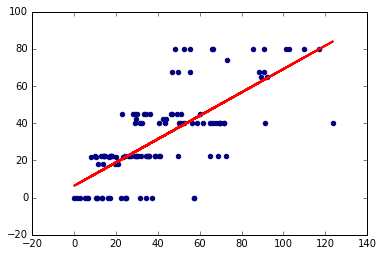

In [35]:
X = df_reg_2["associated_client_count"].reshape(len(df_reg_2["associated_client_count"]), 1)
y = df_reg_2["min_occ_reg"]

lm_scikit_2 = LinearRegression()

# Fit the model 
lm_scikit_2.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit_2.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y, lm_scikit_2.predict(X)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y, lm_scikit_2.predict(X))))
# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit_2.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit_2.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

#### Train & Testing

**Cross Validation**

In [36]:
R2_scores_2 = cross_val_score(lm_scikit_2.fit(X, y), X.astype(int), y.astype(int), cv=5)
print(R2_scores_2)
print(R2_scores_2.mean())

[ 0.16112777  0.17065649  0.31806162  0.48293983  0.38207857]
0.3029728567


**Train and test** 

Coefficients: 
 [ 0.66588293]
Intercept: 
 4.55047712022
Residual sum of squares: 286.13
Square Root of Residual sum of squares: 16.92
Variance score: 0.49


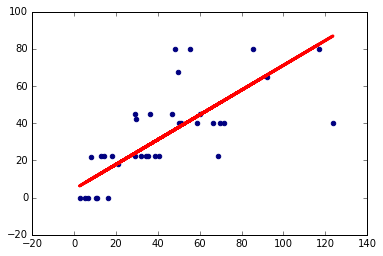

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm_scikit_2_t = LinearRegression()

# Train the model using the training sets
lm_scikit_2_t.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', lm_scikit_2_t.coef_)
# The intercept
print('Intercept: \n', lm_scikit_2_t.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test)))
print("Square Root of Residual sum of squares: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, lm_scikit_2_t.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit_2_t.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit_2_t.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

## Categorical Models

In [38]:
df = df_abt[["occupancy", "authenticated_client_count", "capacity"]].copy()
df = convert_perc_int(df)

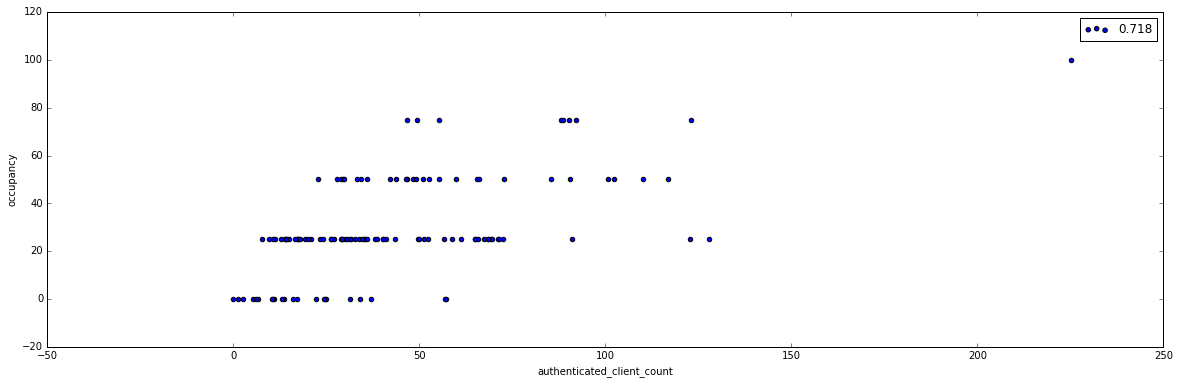

In [39]:
plt.figure() 
df.plot(kind="scatter", x="authenticated_client_count", y="occupancy", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

(121, 4)


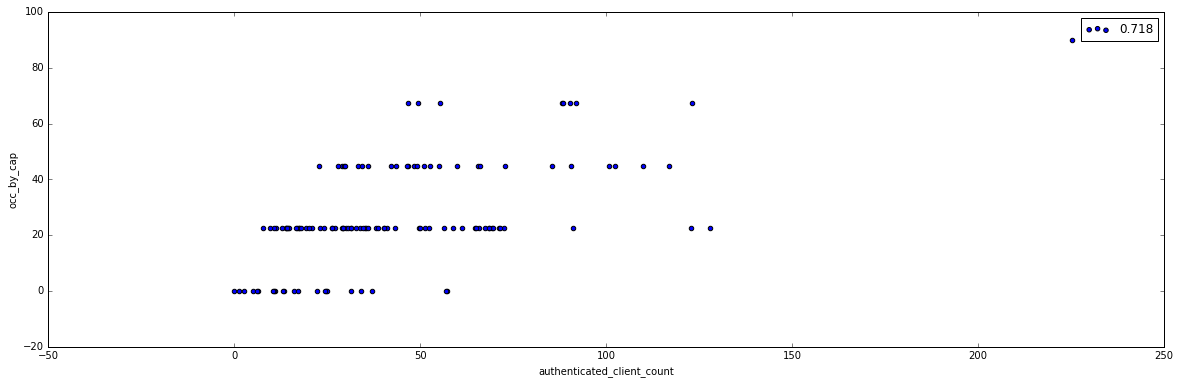

In [40]:
df["occ_by_cap"] = df["occupancy"].copy().apply(lambda x: (x / 100) * df["capacity"].values[0])
print(df.shape)
plt.figure() 
df.plot(kind="scatter", x="authenticated_client_count", y="occ_by_cap", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))

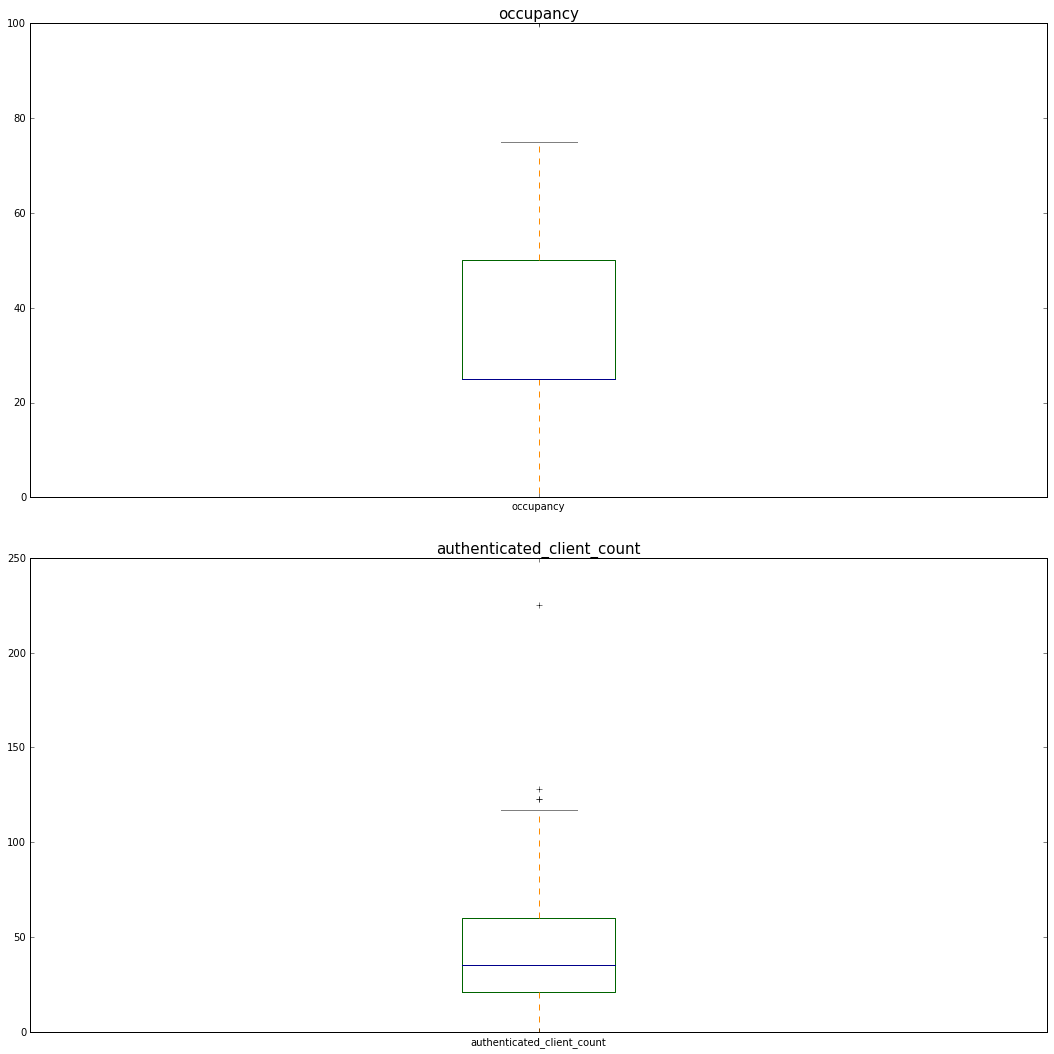

In [41]:
plt.figure() 
plt.subplot(211).set_title("occupancy", fontsize=15)
df["occupancy"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0)

In [42]:
# df["occupancy_NORM"] = normalize(df, "occupancy")
# df["authenticated_client_count_NORM"] = normalize(df, "authenticated_client_count")
# print(df.shape)
# df = removeOutliers(df, "occupancy_NORM")
# df = removeOutliers(df, "authenticated_client_count_NORM")
# df = df[["occupancy", "authenticated_client_count"]]
# print(df.shape)

### Multinomial Logistic Regression http://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/

log-odds of a categorical response being "true" (1) is modeled as a linear combination of the features.
Logistic regression outputs the probabilities of a specific class
Those probabilities can be converted into class predictions

In [43]:
df_log_1 = df.copy()
occ = df_log_1["occupancy"].copy().apply(lambda x: (x / 100) * df_log_1["capacity"].values[0])
EXP = []
for a, o in zip(df_log_1["authenticated_client_count"], occ):
    EXP.append([a, o])

X = np.array(EXP)
# X = df_log_1["authenticated_client_count"].div(df_log_1["capacity"]).reshape(len(df_log_1["authenticated_client_count"]), 1)
# X = df_log_1["authenticated_client_count"].reshape(len(df_log_1["authenticated_client_count"]), 1)
y = df_log_1["occupancy"]
lr = LogisticRegression()
lr.fit(X, y)
pred_lr = lr.predict(X)
df_log_1["predicted"] = pd.Series(pred_lr, index=df_log_1.index)
print(metrics.classification_report(y, pred_lr))
print(metrics.confusion_matrix(y, pred_lr))
print(metrics.accuracy_score(y, pred_lr) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       0.88      1.00      0.93        63
         50       0.67      0.67      0.67        27
         75       0.00      0.00      0.00         8
        100       0.00      0.00      0.00         1

avg / total       0.79      0.85      0.82       121

[[22  0  0  0  0]
 [ 0 63  0  0  0]
 [ 0  9 18  0  0]
 [ 0  0  8  0  0]
 [ 0  0  1  0  0]]
0.851239669421


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Rows where predicted doesn't match actual

In [44]:
df_log_1[df_log_1["occupancy"] != df_log_1["predicted"]]

,occupancy,authenticated_client_count,capacity,occ_by_cap,predicted
63,50,110.000000,160,45.0,25
67,75,123.000000,160,67.5,50
68,100,225.166667,160,90.0,50
70,50,90.600000,160,45.0,25
71,50,102.333333,160,45.0,25
73,50,65.600000,160,45.0,25
90,50,72.833333,160,45.0,25
98,50,100.666667,160,45.0,25
100,50,85.333333,160,45.0,25
101,50,116.833333,160,45.0,25


#### Testing

In [45]:
clf = LogisticRegression()
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.18)


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = LogisticRegression().fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print(score)
pred_log_train = clf.predict(X_test)
print(metrics.classification_report(y_test, pred_log_train))
print(metrics.confusion_matrix(y_test, pred_log_train))
print(metrics.accuracy_score(y_test, pred_log_train))

             precision    recall  f1-score   support

          0       1.00      0.90      0.95        10
         25       0.72      1.00      0.84        23
         50       0.62      0.38      0.48        13
         75       0.00      0.00      0.00         2
        100       0.00      0.00      0.00         1

avg / total       0.71      0.76      0.71        49

[[ 9  1  0  0  0]
 [ 0 23  0  0  0]
 [ 0  8  5  0  0]
 [ 0  0  2  0  0]
 [ 0  0  1  0  0]]
0.755102040816


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
df_log_1["predicted"] = pd.Series(pred_lr, index=df_log_1.index)

In [48]:
####### How to use model to return occupancy prediction #######
# lr.predict_proba(X)
# groups = [0, 25, 50, 75, 100]
# lr.predict_proba(X).argmax(axis=1)

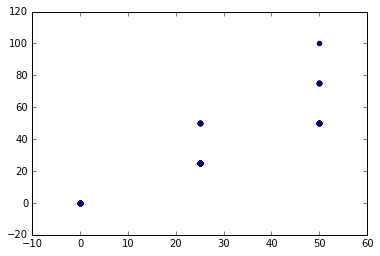

In [49]:
plt.scatter(df_log_1["predicted"], df_log_1["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

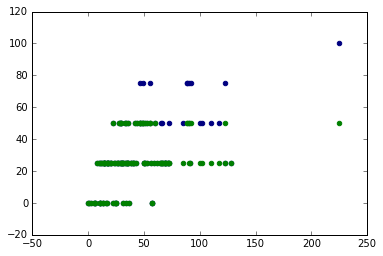

In [50]:
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["occupancy"],  color='navy')
plt.scatter(df_log_1["authenticated_client_count"], df_log_1["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Gaussian Naive Bayes 

In [51]:
df_gnb = df.copy()

occ = df_gnb["occupancy"].copy().apply(lambda x: (x / 100) * df_gnb["capacity"].values[0])
EXP = []
for a, o in zip(df_gnb["authenticated_client_count"], occ):
    EXP.append([a, o])
X = np.array(EXP)
# X = df_gnb["authenticated_client_count"].div(df_gnb["capacity"]).reshape(len(df_gnb["authenticated_client_count"]), 1)
# X = df_gnb["authenticated_client_count"].reshape(len(df_gnb["authenticated_client_count"]), 1)
y = df_gnb["occupancy"]
# fit a Naive Bayes model to the data
gnb = GaussianNB()
gnb.fit(X, y)
pred_gnb = gnb.predict(X)
df_gnb["predicted"] = pd.Series(pred_gnb, index=df_gnb.index)
print(metrics.classification_report(y, pred_gnb))
print(metrics.confusion_matrix(y, pred_gnb))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       1.00      1.00      1.00        63
         50       1.00      1.00      1.00        27
         75       1.00      1.00      1.00         8
        100       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00       121

[[22  0  0  0  0]
 [ 0 63  0  0  0]
 [ 0  0 27  0  0]
 [ 0  0  0  8  0]
 [ 0  0  0  0  1]]


In [52]:
df_gnb[df_gnb["occupancy"] != df_gnb["predicted"]]

,occupancy,authenticated_client_count,capacity,occ_by_cap,predicted


#### Testing

In [53]:
clf = GaussianNB()
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.03)


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = GaussianNB().fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print(score)
pred_gnb_train = clf.predict(X_test)
print(metrics.classification_report(y_test, pred_gnb_train))
print(metrics.confusion_matrix(y_test, pred_gnb_train))
print(metrics.accuracy_score(y_test, pred_gnb_train))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
         25       1.00      1.00      1.00        23
         50       1.00      1.00      1.00        13
         75       0.67      1.00      0.80         2
        100       0.00      0.00      0.00         1

avg / total       0.97      0.98      0.97        49

[[10  0  0  0  0]
 [ 0 23  0  0  0]
 [ 0  0 13  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  1  0]]
0.979591836735


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
df_gnb["predicted"] = pd.Series(pred_gnb, index=df_gnb.index)

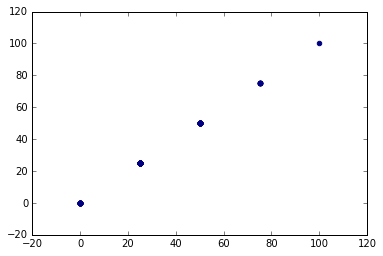

In [56]:
plt.scatter(df_gnb["predicted"], df_gnb["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

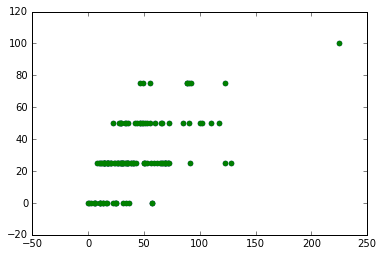

In [57]:
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["occupancy"],  color='navy')
plt.scatter(df_gnb["authenticated_client_count"], df_gnb["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### k-Nearest Neighbor

In [58]:
df_nn = df.copy()
occ = df_nn["occupancy"].copy().apply(lambda x: (x / 100) * df_nn["capacity"].values[0])
EXP = []
for a, o in zip(df_nn["authenticated_client_count"], occ):
    EXP.append([a, o])
X = np.array(EXP)

# X = df_nn["authenticated_client_count"].div(df_nn["capacity"]).reshape(len(df_nn["authenticated_client_count"]), 1)
# X = df_nn["authenticated_client_count"].reshape(len(df_nn["authenticated_client_count"]), 1)
y = df_nn["occupancy"] 
nn = KNeighborsClassifier() # default n_neighbors=5
nn.fit(X, y)
pred_nn = nn.predict(X)
df_nn["predicted"] = pd.Series(pred_nn, index=df_nn.index)
print(metrics.classification_report(y, pred_nn))
print(metrics.confusion_matrix(y, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       0.98      0.97      0.98        63
         50       0.90      1.00      0.95        27
         75       1.00      0.88      0.93         8
        100       0.00      0.00      0.00         1

avg / total       0.96      0.97      0.96       121

[[22  0  0  0  0]
 [ 0 61  2  0  0]
 [ 0  0 27  0  0]
 [ 0  0  1  7  0]
 [ 0  1  0  0  0]]


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
df_nn[df_nn["occupancy"] != df_nn["predicted"]]

,occupancy,authenticated_client_count,capacity,occ_by_cap,predicted
67,75,123.000000,160,67.5,50
68,100,225.166667,160,90.0,25
72,25,122.833333,160,22.5,50
99,25,127.857143,160,22.5,50


#### Testing

In [60]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.06)


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
scores=[]
for n in range(2,15):
    clf = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    scores.append(round(clf.score(X_test, y_test),2))
neighbours = scores.index(max(scores)) + 1
# print(scores)
clf = KNeighborsClassifier(n_neighbors=neighbours).fit(X_train, y_train)
pred_knn_train = clf.predict(X_test)
print(metrics.classification_report(y_test, pred_knn_train))
print(metrics.confusion_matrix(y_test, pred_knn_train))
print(metrics.accuracy_score(y_test, pred_knn_train))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
         25       1.00      1.00      1.00        23
         50       1.00      1.00      1.00        13
         75       0.67      1.00      0.80         2
        100       0.00      0.00      0.00         1

avg / total       0.97      0.98      0.97        49

[[10  0  0  0  0]
 [ 0 23  0  0  0]
 [ 0  0 13  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  1  0]]
0.979591836735


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
df_nn["predicted"] = pd.Series(pred_nn, index=df_nn.index)

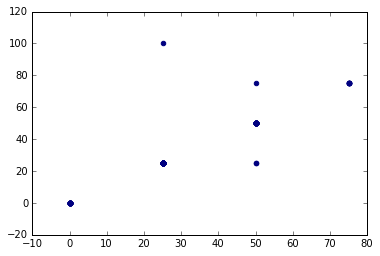

In [63]:
plt.scatter(df_nn["predicted"], df_nn["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

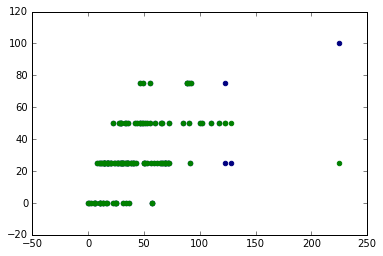

In [64]:
plt.scatter(df_nn["authenticated_client_count"], df_nn["occupancy"],  color='navy')
plt.scatter(df_nn["authenticated_client_count"], df_nn["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()

### Support Vector Machines

In [65]:
df_svm = df.copy()

occ = df_svm["occupancy"].copy().apply(lambda x: (x / 100) * df_svm["capacity"].values[0])
EXP = []
for a, o in zip(df_svm["authenticated_client_count"], occ):
    EXP.append([a, o])
X = np.array(EXP)

# X = df_svm["authenticated_client_count"].div(df_svm["capacity"]).reshape(len(df_svm["authenticated_client_count"]), 1)
# X = df_svm["authenticated_client_count"].reshape(len(df_svm["authenticated_client_count"]), 1)
y = df_svm["occupancy"] 
svc = SVC()
svc.fit(X, y)
pred_svm = svc.predict(X)
df_svm["predicted"] = pd.Series(pred_svm, index=df_svm.index)
print(metrics.classification_report(y, pred_svm))
print(metrics.confusion_matrix(y, pred_svm))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
         25       1.00      1.00      1.00        63
         50       1.00      1.00      1.00        27
         75       1.00      1.00      1.00         8
        100       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00       121

[[22  0  0  0  0]
 [ 0 63  0  0  0]
 [ 0  0 27  0  0]
 [ 0  0  0  8  0]
 [ 0  0  0  0  1]]


In [66]:
df_svm[df_svm["occupancy"] != df_svm["predicted"]]

,occupancy,authenticated_client_count,capacity,occ_by_cap,predicted


#### Testing

In [67]:
clf = SVC()
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.74074074  0.73076923  0.75        0.81818182  0.95454545]
Accuracy: 0.80 (+/- 0.17)


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = SVC().fit(X_train, y_train)
# score = clf.score(X_test, y_test)
# print(score)
pred_svm_train = clf.predict(X_test)
print(metrics.classification_report(y_test, pred_svm_train))
print(metrics.confusion_matrix(y_test, pred_svm_train))

             precision    recall  f1-score   support

          0       1.00      0.20      0.33        10
         25       0.53      1.00      0.70        23
         50       1.00      0.31      0.47        13
         75       0.00      0.00      0.00         2
        100       0.00      0.00      0.00         1

avg / total       0.72      0.59      0.52        49

[[ 2  8  0  0  0]
 [ 0 23  0  0  0]
 [ 0  9  4  0  0]
 [ 0  2  0  0  0]
 [ 0  1  0  0  0]]


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
scores=[]
for n in range(0,20):
    clf = SVC(gamma=n).fit(X_train, y_train)
    scores.append(round(clf.score(X_test, y_test),2))
print(scores)
gamma = scores.index(max(scores))
print(gamma)

[0.58999999999999997, 0.55000000000000004, 0.51000000000000001, 0.51000000000000001, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.48999999999999999, 0.46999999999999997, 0.46999999999999997, 0.46999999999999997, 0.46999999999999997]
0


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)


In [70]:
df_svm["predicted"] = pd.Series(pred_svm, index=df_svm.index)

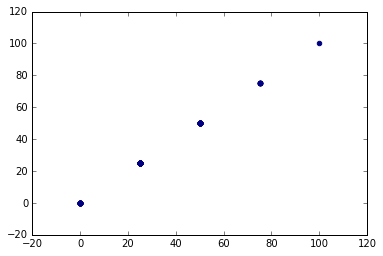

In [71]:
plt.scatter(df_svm["predicted"], df_svm["occupancy"],  color='navy')
plt.figure(figsize=(20,20))
plt.show()

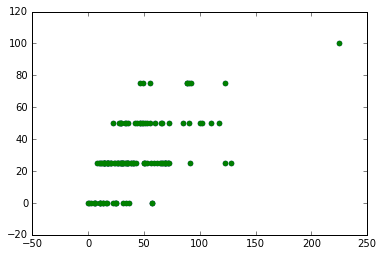

In [72]:
plt.scatter(df_svm["authenticated_client_count"], df_svm["occupancy"],  color='navy')
plt.scatter(df_svm["authenticated_client_count"], df_svm["predicted"],  color='green')
plt.figure(figsize=(20,20))
plt.show()